In [1]:
import pandas as pd
import json
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

# Importar funcion de seleccion de features
from package_ml.modeling.selection import get_permutation_importance

2025-06-21 18:57:45.731 | INFO     | package_ml.config:<module>:11 - PROJ_ROOT path is: /home/fernando/Documentos/azure_ml


In [2]:
DATA_PATH = Path('../data/interim/train_fe.parquet')
df = pd.read_parquet(DATA_PATH)

In [3]:
TARGET = "Calories"
FEATURES = [col for col in df.columns if col not in [TARGET, "User_ID"]]

In [4]:
y = df[TARGET]
X = df[FEATURES]

In [6]:
importance_df = get_permutation_importance(X, y)

# Mostrar las características con importancia positiva
print("\n--- Ranking de Importancia de Características (solo con impacto positivo) ---")
important_features_ranked = importance_df[importance_df['importance_mean'] > 0]
important_features_ranked

División de datos: 160000 para entrenar, 40000 para validar.
Entrenando modelo base para la evaluación de características...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011344 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11516
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 63
[LightGBM] [Info] Start training from score 4.139956
Calculando importancias en el set de validación...
--- Cálculo de Permutación de Importancia completado ---

--- Ranking de Importancia de Características (solo con impacto positivo) ---


,feature,importance_mean,importance_std
62,feno_var,65.367351,0.203577
0,Gender,6.828729,0.023551
19,Duration_x_Heart_Rate,5.691520,0.030396
21,Heart_Rate_x_Body_Temp,3.894347,0.031109
52,Percent_FCMT_tanaka,3.771036,0.011706
29,Age_x_Duration_x_Heart_Rate,3.405911,0.059119
41,Duration_x_Heart_Rate_x_Body_Temp,1.039398,0.018192
3,Weight,0.787331,0.014036
12,Height_x_Weight,0.493005,0.009871
26,Age_x_Weight_x_Duration,0.476422,0.021314


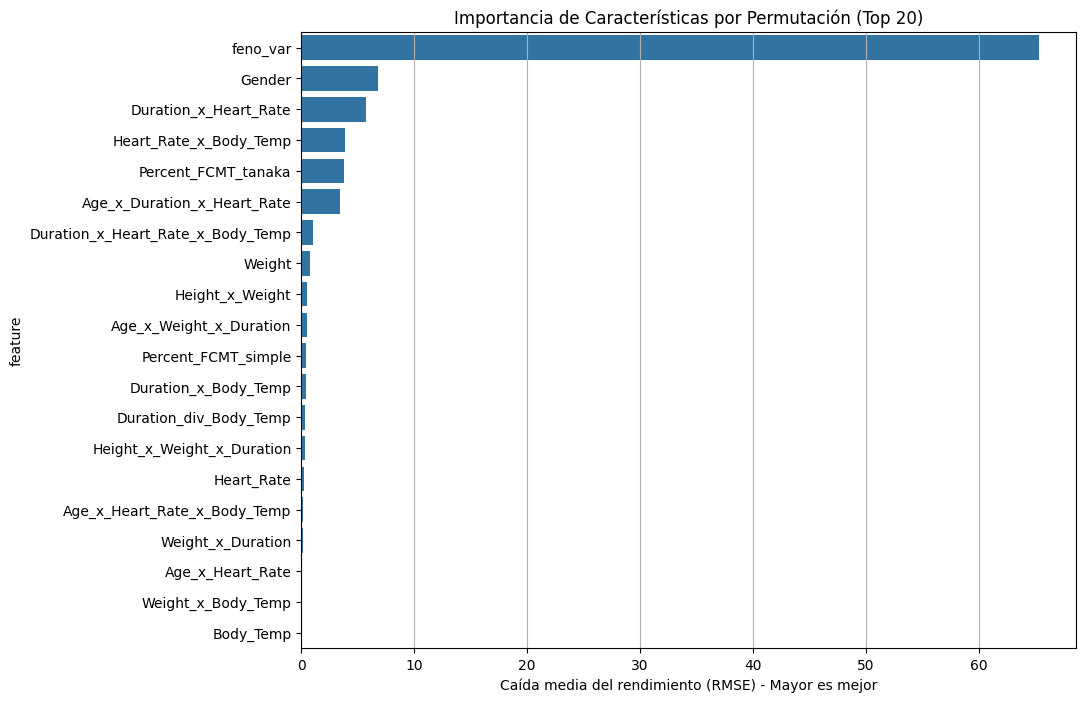

In [7]:
# Visualizar las más importantes para ayudar en la decisión
plt.figure(figsize=(10, 8))
sns.barplot(
    x='importance_mean', 
    y='feature', 
    data=important_features_ranked.head(20) # Visualizamos las 20 mejores
)
plt.title('Importancia de Características por Permutación (Top 20)')
plt.xlabel('Caída media del rendimiento (RMSE) - Mayor es mejor')
plt.grid(axis='x')
plt.show()

In [10]:
# Definimos manualmente las que tienen mas sentido
final_selected_features = [
    'feno_var',
    'Gender',
    'Duration_x_Heart_Rate',
    'Heart_Rate_x_Body_Temp',
    'Percent_FCMT_tanaka',
    'Age_x_Duration_x_Heart_Rate',
    'Age',
    'Height',
    'Weight',
    'Duration',
    'Heart_Rate',
    'Body_Temp'
]

In [11]:
# Filtrar el DataFrame X para las siguientes etapas
X_selected = X[final_selected_features]

# Guardar esta lista para reproducibilidad y para las siguientes etapas
MODELS_DIR = Path('../models')
MODELS_DIR.mkdir(exist_ok=True)
features_path = MODELS_DIR / 'final_features.json'

with open(features_path, 'w') as f:
    json.dump(final_selected_features, f)

print(f"\nLista de características finales guardada en: {features_path}")


Lista de características finales guardada en: ../models/final_features.json


## Optimizacion de hiperparametros

In [11]:
from package_ml.modeling.train import optimize_lgbm_hyperparameters
import json
from pathlib import Path

In [6]:
# Cargar las características seleccionadas previamente
with open('../models/final_features.json', 'r') as f:
    final_selected_features = json.load(f)

# Filtrar el DataFrame X
X_selected = X[final_selected_features]

In [7]:
X_selected.head()

,feno_var,Gender,Duration_x_Heart_Rate,Heart_Rate_x_Body_Temp,Percent_FCMT_tanaka,Age_x_Duration_x_Heart_Rate,Age,Height,Weight,Duration,Heart_Rate,Body_Temp
0,583.6960,False,1600.0,4040.0,51.733057,33600.0,21.0,188.0,84.0,16.0,100.0,40.4
1,356.7674,False,1001.0,3658.2,52.178899,48048.0,48.0,165.0,68.0,11.0,91.0,40.2
2,709.3430,True,2369.0,4171.5,54.670913,66332.0,28.0,178.0,77.0,23.0,103.0,40.5
3,1036.5180,False,3045.0,4315.5,56.573276,97440.0,32.0,156.0,54.0,29.0,105.0,41.1
4,79.3992,True,462.0,3033.8,40.271967,11088.0,24.0,172.0,75.0,6.0,77.0,39.4


In [8]:
study = optimize_lgbm_hyperparameters(
    X=X_selected,
    y=y,
    stratify_on=df['Gender'],
    n_trials=30,
    cv_splits=5
)

[I 2025-06-21 18:58:16,921] A new study created in memory with name: calories_lgbm


Iniciando estudio de Optuna bajo la ejecución principal de MLflow: 3689c53f6ab0476b8c66f4eecb3103ef


[I 2025-06-21 18:59:08,076] Trial 0 finished with value: 6.960837370129754 and parameters: {'n_estimators': 2129, 'learning_rate': 0.00163085414574728, 'num_leaves': 481, 'max_depth': 8, 'min_child_samples': 92, 'subsample': 0.7839986396196956, 'colsample_bytree': 0.6135072154166972, 'lambda_l1': 0.002106408432666141, 'lambda_l2': 0.05839077809486109}. Best is trial 0 with value: 6.960837370129754.
[I 2025-06-21 18:59:25,753] Trial 1 finished with value: 20.746119694769465 and parameters: {'n_estimators': 1834, 'learning_rate': 0.0016969258876170013, 'num_leaves': 239, 'max_depth': 1, 'min_child_samples': 25, 'subsample': 0.9722253846550207, 'colsample_bytree': 0.9308159985223406, 'lambda_l1': 0.051396627990615555, 'lambda_l2': 0.0006314292637862797}. Best is trial 0 with value: 6.960837370129754.
[I 2025-06-21 19:01:13,104] Trial 2 finished with value: 3.780776583866455 and parameters: {'n_estimators': 3368, 'learning_rate': 0.0021064300242400777, 'num_leaves': 505, 'max_depth': 13, '

Optimización completada. Registrando los mejores resultados.


In [9]:
print("▶ Best RMSE:", study.best_value)
print("▶ Best params:", study.best_params)

▶ Best RMSE: 3.665727813692213
▶ Best params: {'n_estimators': 3116, 'learning_rate': 0.01000217020641333, 'num_leaves': 218, 'max_depth': 12, 'min_child_samples': 25, 'subsample': 0.6083028313364426, 'colsample_bytree': 0.6031576305580872, 'lambda_l1': 0.04409329013076631, 'lambda_l2': 0.00045456771524267397}


In [10]:
# Guardar los mejores parámetros en un archivo para la etapa final
MODELS_DIR = Path('../models')
best_params_path = MODELS_DIR / 'best_lgbm_params.json'

with open(best_params_path, 'w') as f:
    json.dump(study.best_params, f)